## Differential DNA methylation with Illumina 450K arrays

This notebook compares DNA methylation between two groups using Illumina HumanMethylation450 (“450K”) arrays.
- We use minfi to read IDATs, run QC, and perform functional normalization,
- limma for CpG-level differential methylation,
- DMRcate for region-level DMRs,
- missMethyl to perform corrected gene set tests.

The example dataset is GEO GSE47915 (benign prostate tissue vs tumor; 8 total samples).

In [1]:
# Paths
data_dir <- "data"
downloader <- file.path(data_dir, "downloaders", "download_geo_gse47915.R")

# Packages
suppressPackageStartupMessages({
  library(minfi)
  library(limma)
  library(DMRcate)
  library(missMethyl)
  library(ggplot2)
  library(S4Vectors)
})

# Download dataset (creates ds_dir with idats/ + targets.csv)
# targets.csv is the contract between the downloader and minfi. It contains:
# - Basename: path prefix to *_Grn.idat and *_Red.idat files
# - Sample_Group: labels used throughout (tumor vs benign)
source(downloader)
ds_dir <- download_if_missing(data_dir, gse = "GSE47915")

## 2) Load the IDATs into minfi

IDATs store raw fluorescence for each probe in two channels: Red/Green.
RGChannelSet (rgSet) is the raw container minfi uses to hold those channel intensities + sample metadata (colData).

`targets.csv` provides a "Basename" (a file prefix) per sample pointing to the paired *_Grn.idat / *_Red.idat files.
We load the IDATs into an RGChannelSet, then attach the targets table as phenotype metadata.


In [2]:
targets <- read.csv(file.path(ds_dir, "targets.csv"))
targets

rgSet <- minfi::read.metharray.exp(
    base = file.path(ds_dir, "idats"),
    targets = targets,
    extended = TRUE  # keeps additional control/probe information for downstream steps
)

# store phenotype directly on the object
colnames(rgSet) <- targets$Sample_Name
colData(rgSet)  <- S4Vectors::DataFrame(targets, row.names = colnames(rgSet))

rgSet
table(colData(rgSet)$Sample_Group)

Sample_Name,geo_accession,title,Sample_Group,Basename
<chr>,<chr>,<chr>,<chr>,<chr>
GSM1162363_6264509108_R01C02,GSM1162363,6264509108_Benign_prostate_cancer_HM450K,benign,idats/GSM1162363_6264509108_R01C02
GSM1162364_6264509130_R04C02,GSM1162364,6264509130_1_Tumor_prostate_cancer_Gleason6_HM450K,tumor,idats/GSM1162364_6264509130_R04C02
GSM1162365_6264509130_R03C02,GSM1162365,6264509130_2_Tumor_prostate_cancer_Gleason6_HM450K,tumor,idats/GSM1162365_6264509130_R03C02
GSM1162369_6264509130_R06C01,GSM1162369,6264509130_3_Tumor_prostate_cancer_Gleason6_HM450K,tumor,idats/GSM1162369_6264509130_R06C01
GSM1162375_6264509130_R05C01,GSM1162375,6264509130_4_Tumor_prostate_cancer_Gleason6_HM450K,tumor,idats/GSM1162375_6264509130_R05C01
GSM1162380_6285609104_R03C02,GSM1162380,6285609104 _Benign_prostate_cancer_HM450K,benign,idats/GSM1162380_6285609104_R03C02
GSM1162381_6285650040_R06C02,GSM1162381,6285650040 _Benign_prostate_cancer_HM450K,benign,idats/GSM1162381_6285650040_R06C02
GSM1162382_6285650050_R01C01,GSM1162382,6285650050_Benign_prostate_cancer_HM450K,benign,idats/GSM1162382_6285650050_R01C01


class: RGChannelSetExtended 
dim: 622399 8 
metadata(0):
assays(5): Green Red GreenSD RedSD NBeads
rownames(622399): 10600313 10600322 ... 74810490 74810492
rowData names(0):
colnames(8): GSM1162363_6264509108_R01C02 GSM1162364_6264509130_R04C02
  ... GSM1162381_6285650040_R06C02 GSM1162382_6285650050_R01C01
colData names(5): Sample_Name geo_accession title Sample_Group Basename
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19


benign  tumor 
     4      4 

## 3) Quality control

450K arrays give two intensities per CpG: methylated (M) and unmethylated (U).

Two common early checks are:
- **Median intensity QC**: samples with unusually low methylated/unmethylated signal are often poor-quality. Additionally, samples that aren't in the main cluster of points may be outliers. We'll see this with `plotQC`.
- **Detection p-values**: quantify whether a probe’s signal is distinguishable from background in that sample.

The p-value in this context is how strong the probe fluorescence is compared to negative-control probes. P=0.01 means a probe has an intensity like the 99th percentile of negative-control probes in that sample.



Loading required package: IlluminaHumanMethylation450kmanifest



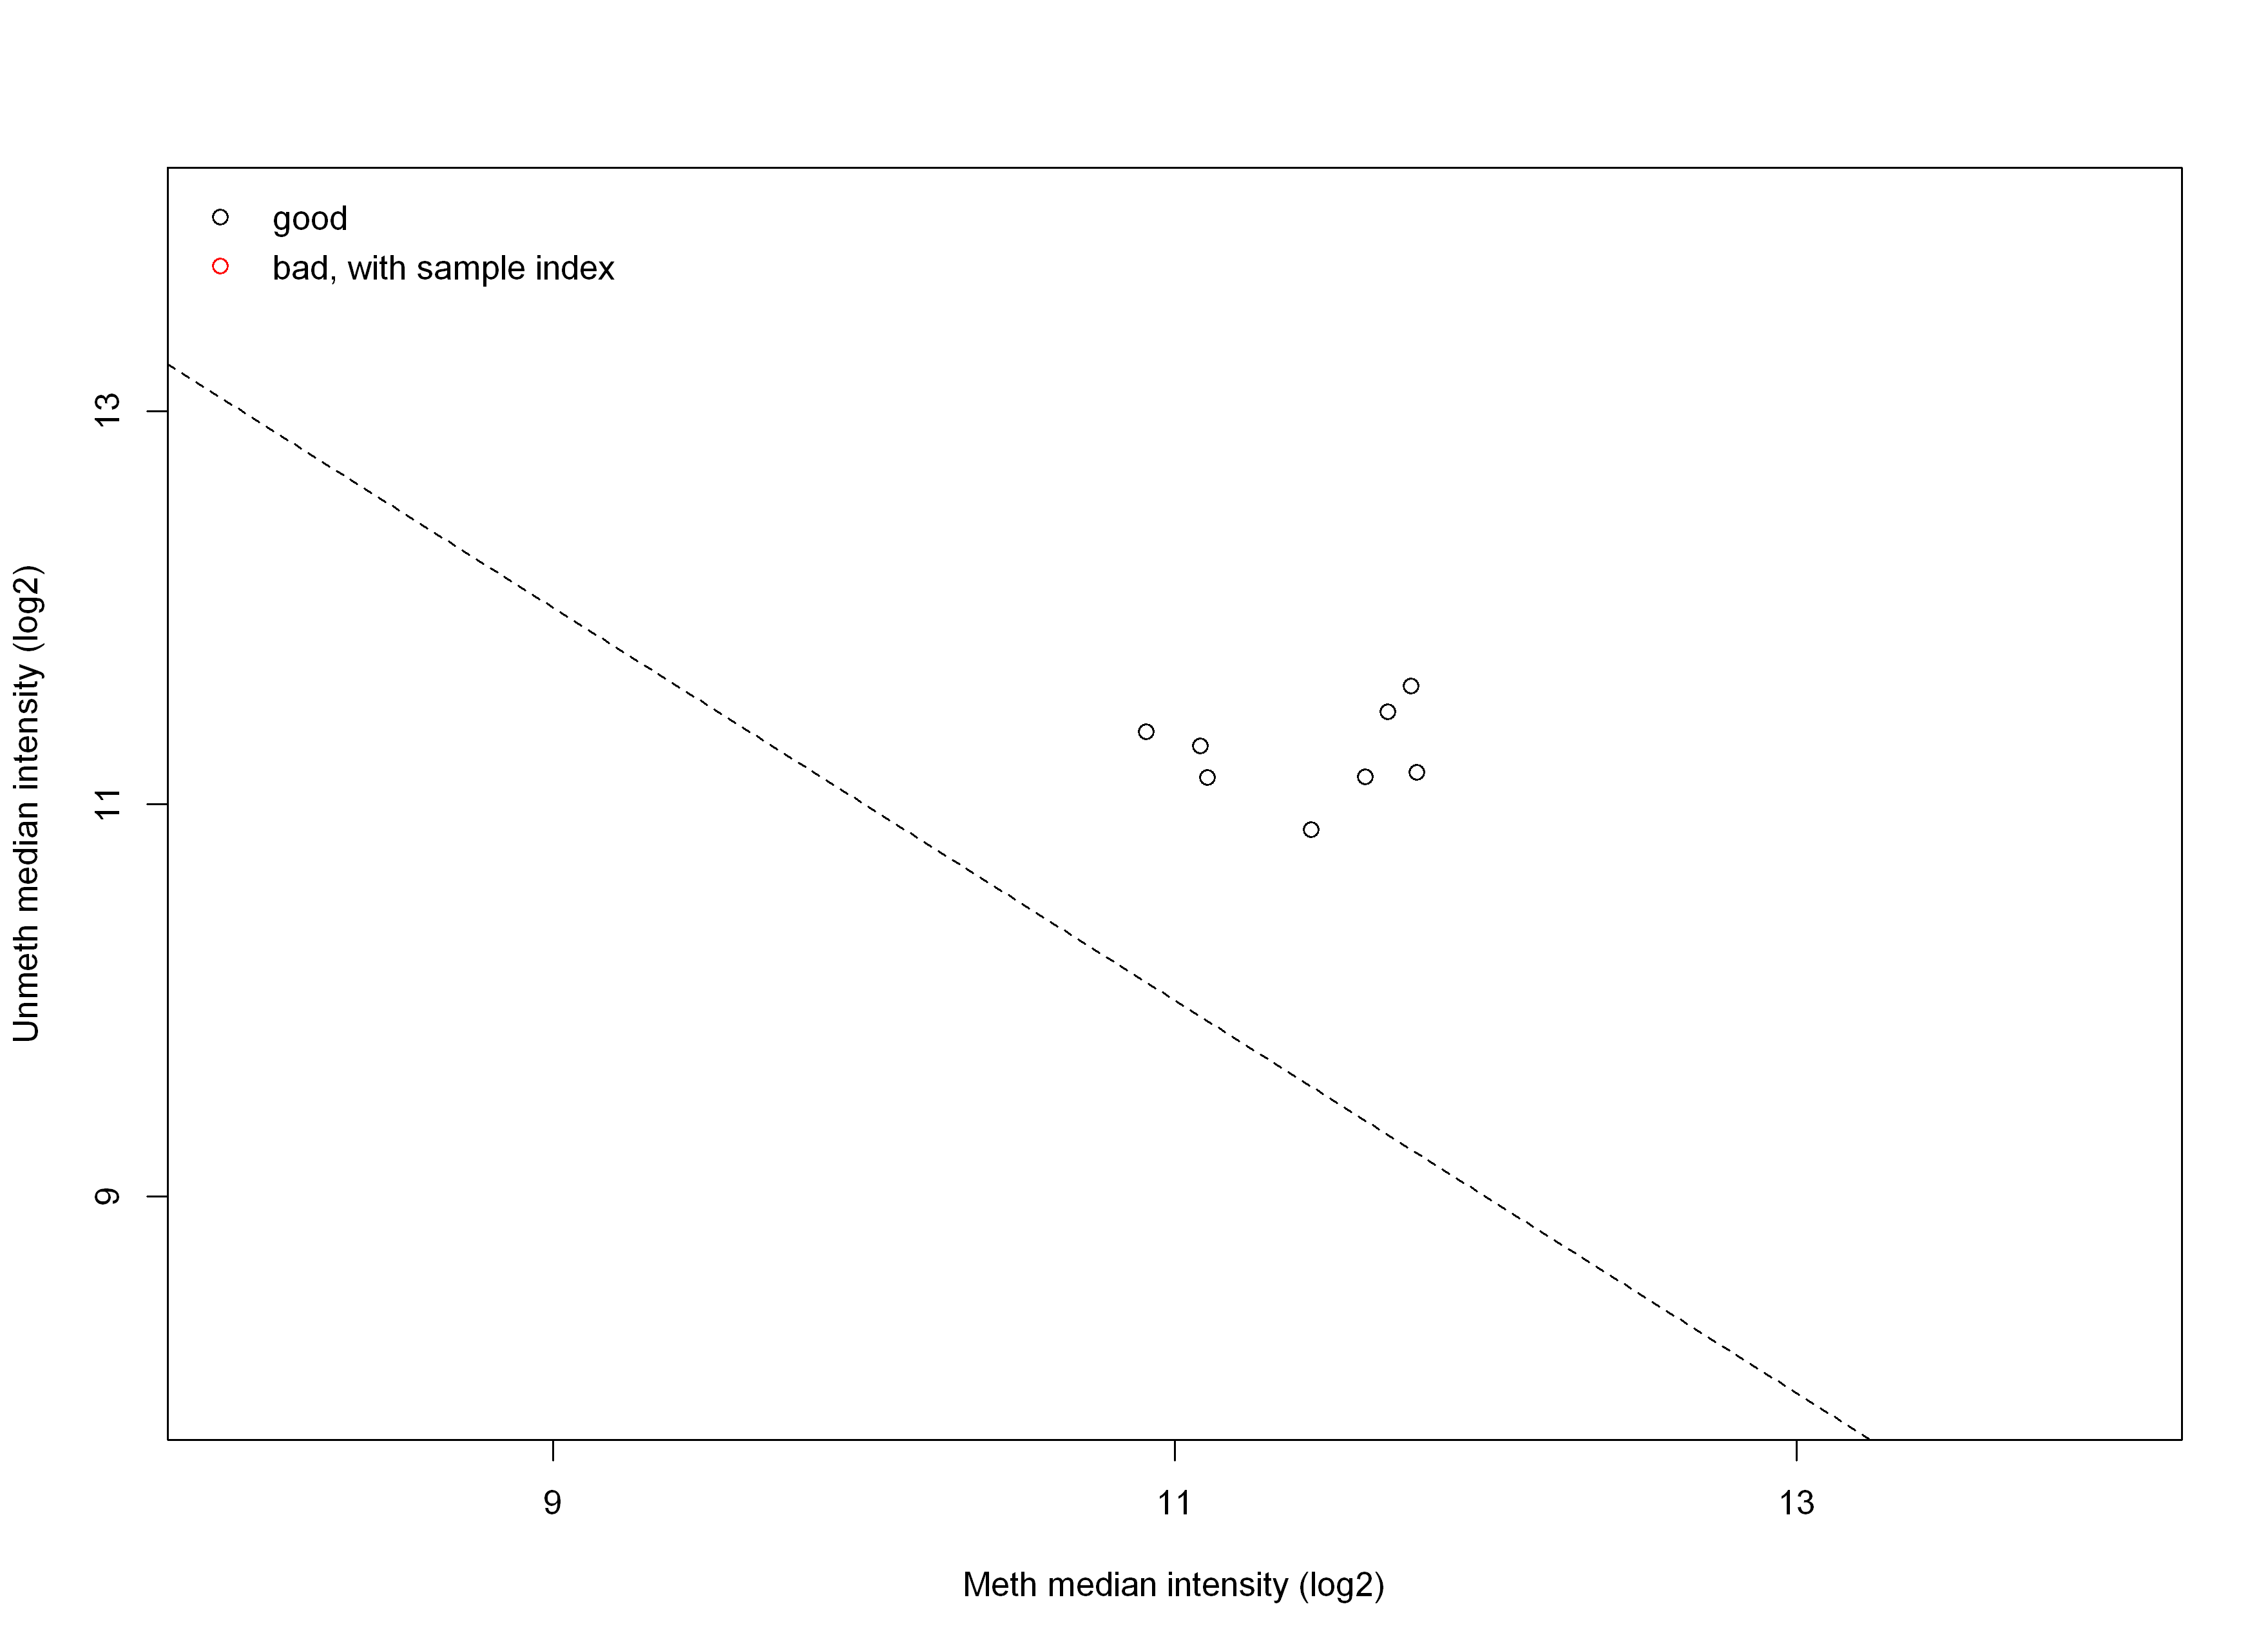

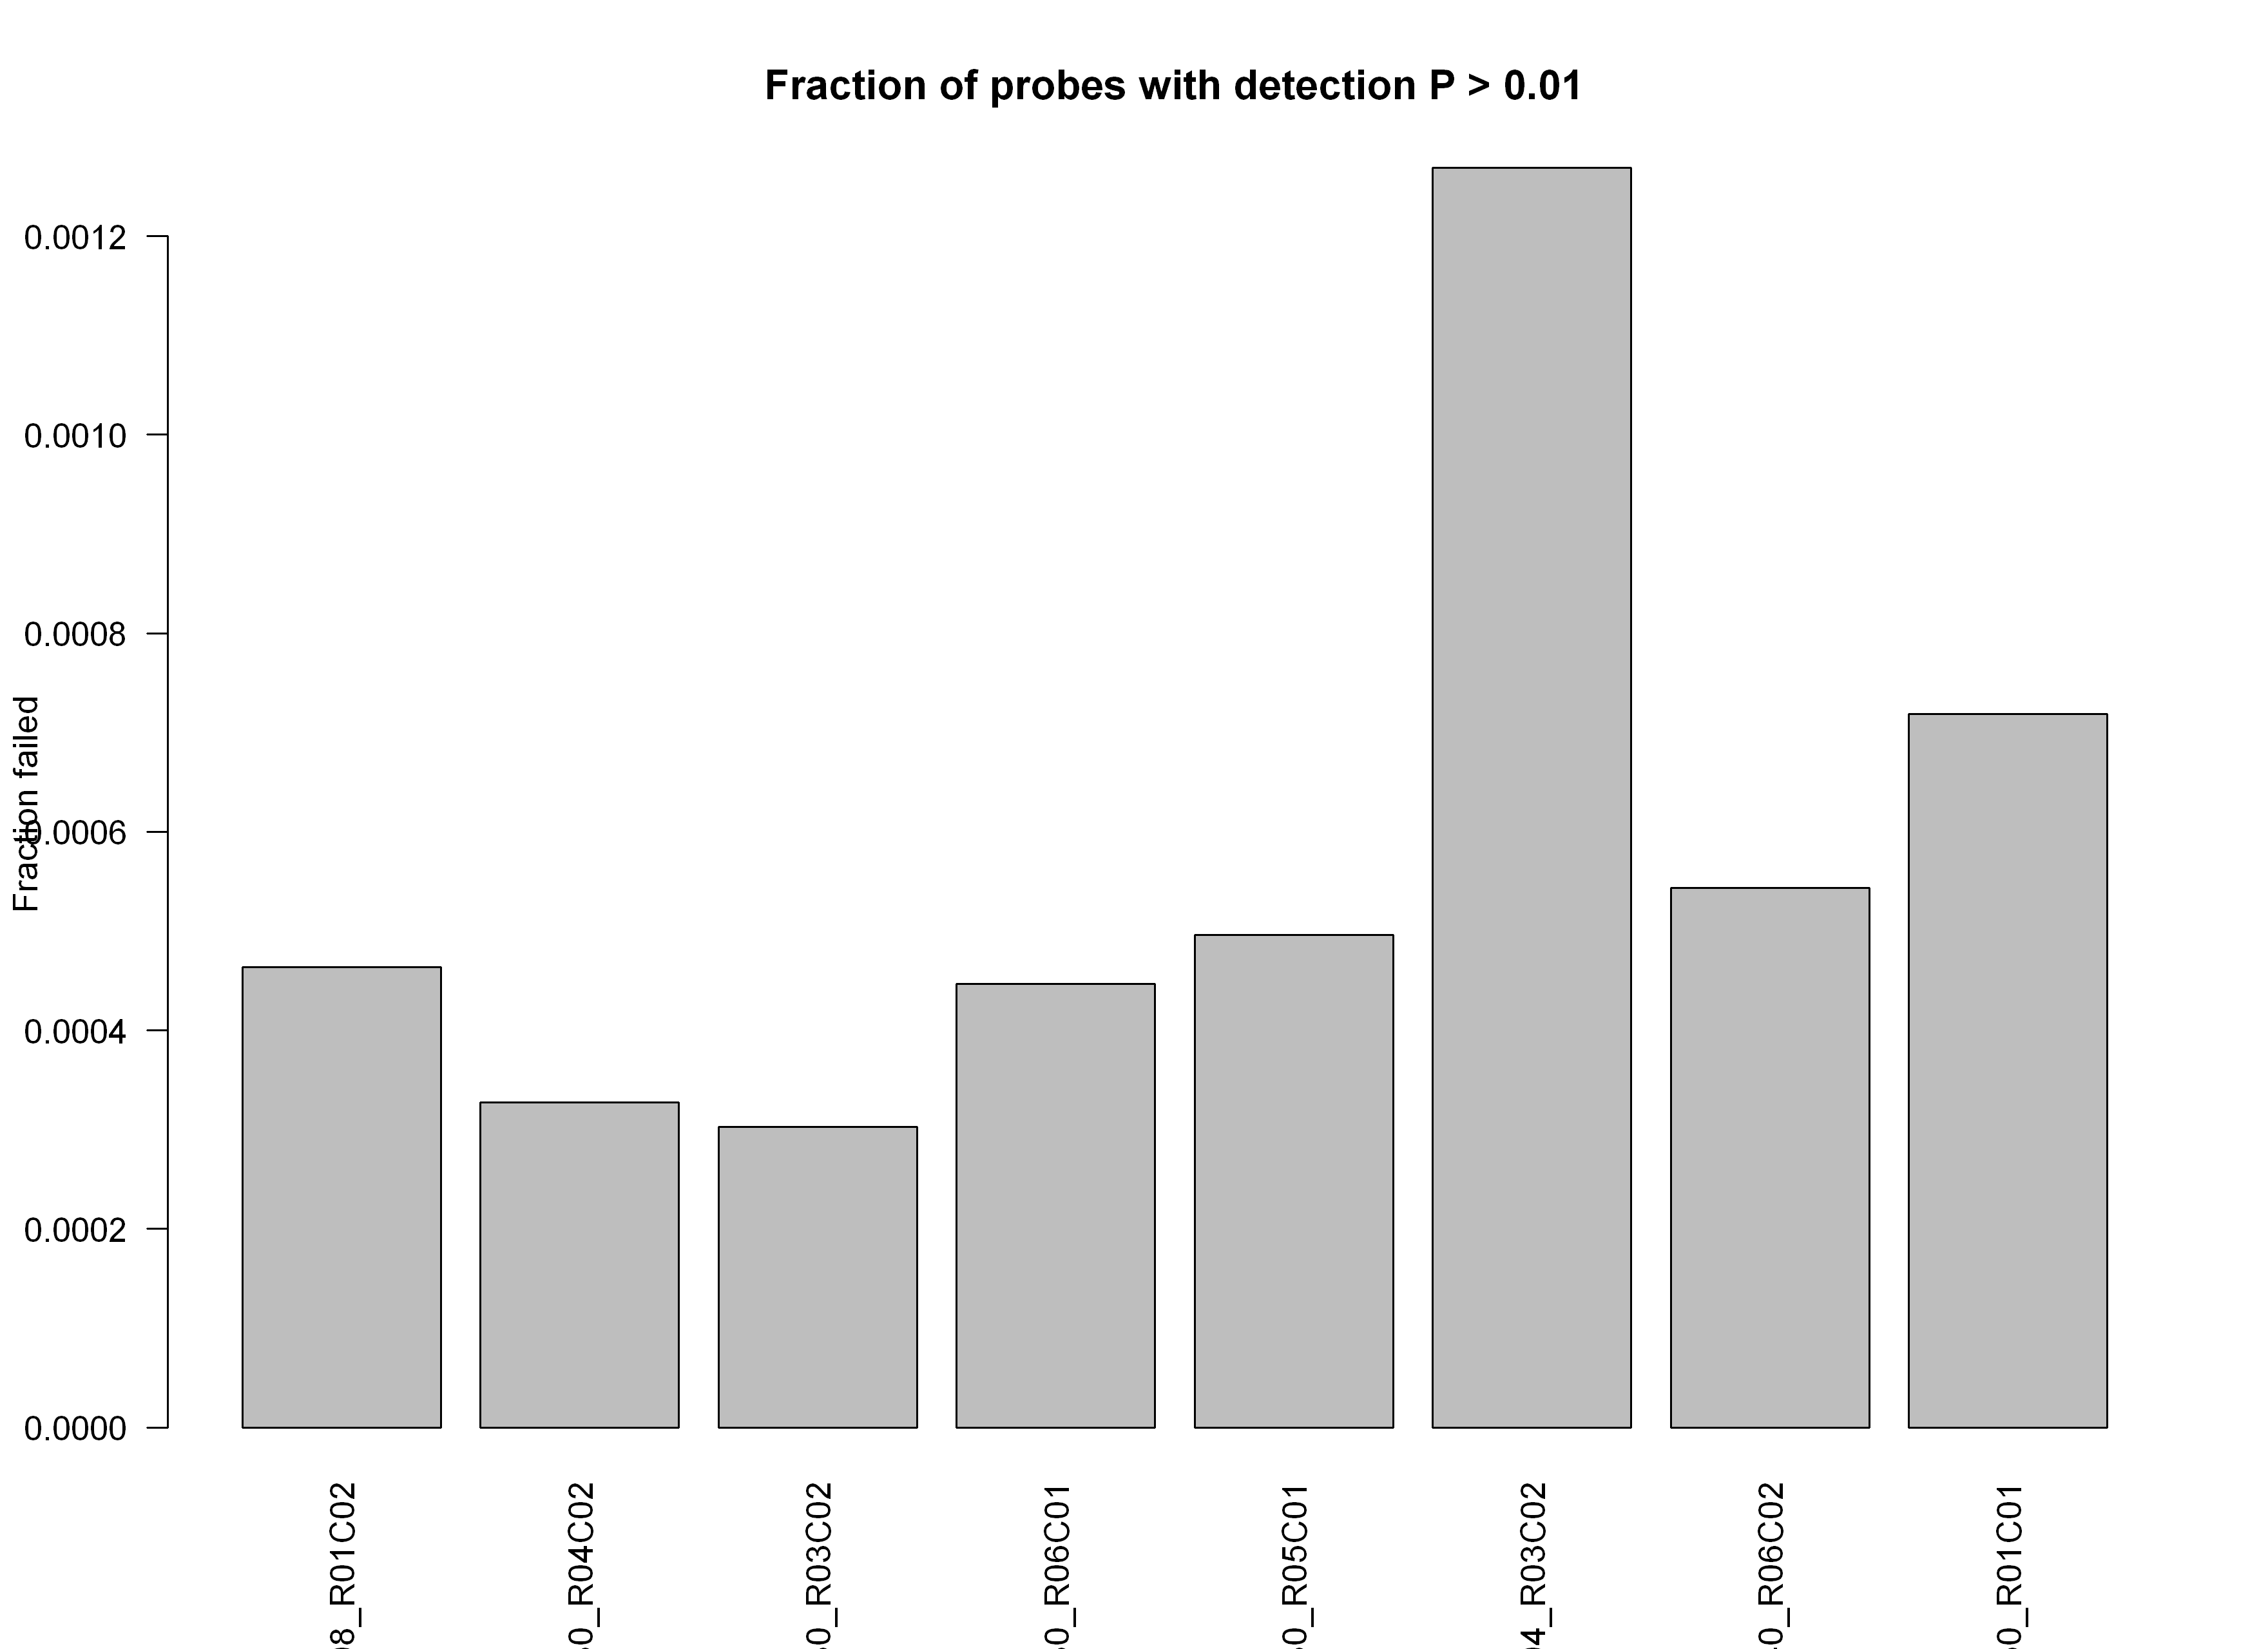

In [3]:
mSet_raw <- minfi::preprocessRaw(rgSet)
qc <- minfi::getQC(mSet_raw)
minfi::plotQC(qc)
# extreme outliers from the main cluster may be removed before normalization/testing.

detP <- detectionP(rgSet)

frac_failed <- colMeans(detP > 0.01, na.rm = TRUE)
barplot(frac_failed, las = 2,
        main = "Fraction of probes with detection P > 0.01",
        ylab = "Fraction failed")

## 4) Normalization + quick exploration of Beta and M-values
Illumina methylation arrays measure two fluorescence intensities at each CpG probe: the methylated and unmethylated signal intensity.
From these, we compute two common methylation measures:
- Beta values are the estimated fraction methylated at a CpG. Ranges from 0 to 1 (0 = mostly unmethylated, 1 = mostly methylated). Best for plots and effect sizes, e.g. Δβ = mean(β_tumor) − mean(β_benign).
Downside: Beta values have non-constant variance (values near 0/1 behave differently than values near 0.5), which is inconvenient for standard linear models.
- M-values are the log-ratio of methylated to unmethylated signal. Ranges from −∞ to +∞. More symmetric and closer to “normal-like” behavior across the genome, so they’re the default for limma and many other linear-model based tests.

We typically fit models on M-values (better statistics) but report and interpret Δβ (more intuitive biology).

We’ll use functional normalization because it reduces between-array technical variation using control-probe signal while aiming to preserve global biological differences. `preprocessFunnorm()` also performs Noob-style background correction (and dye-bias correction), so we still get the benefits of out-of-band background correction.

Typical quick plots: 
- Beta density: samples should have broadly similar bimodal shapes with peaks near low and high methylation (common in array data). Strong shifts/outliers can indicate technical issues or extreme biology.
- MDS/PCA: MDS places samples close together if their genome-wide methylation profiles are similar. If samples cluster by sample group, that supports a biological signal. If they cluster by technical factors (slide/plate/run date), that suggests batch effects you may need to model.

[preprocessFunnorm] Background and dye bias correction with noob

[preprocessFunnorm] Mapping to genome

[preprocessFunnorm] Quantile extraction

Warning message in .getSex(CN = CN, xIndex = xIndex, yIndex = yIndex, cutoff = cutoff):
"An inconsistency was encountered while determining sex. One possibility is that only one sex is present. We recommend further checks, for example with the plotSex function."
[preprocessFunnorm] Normalization



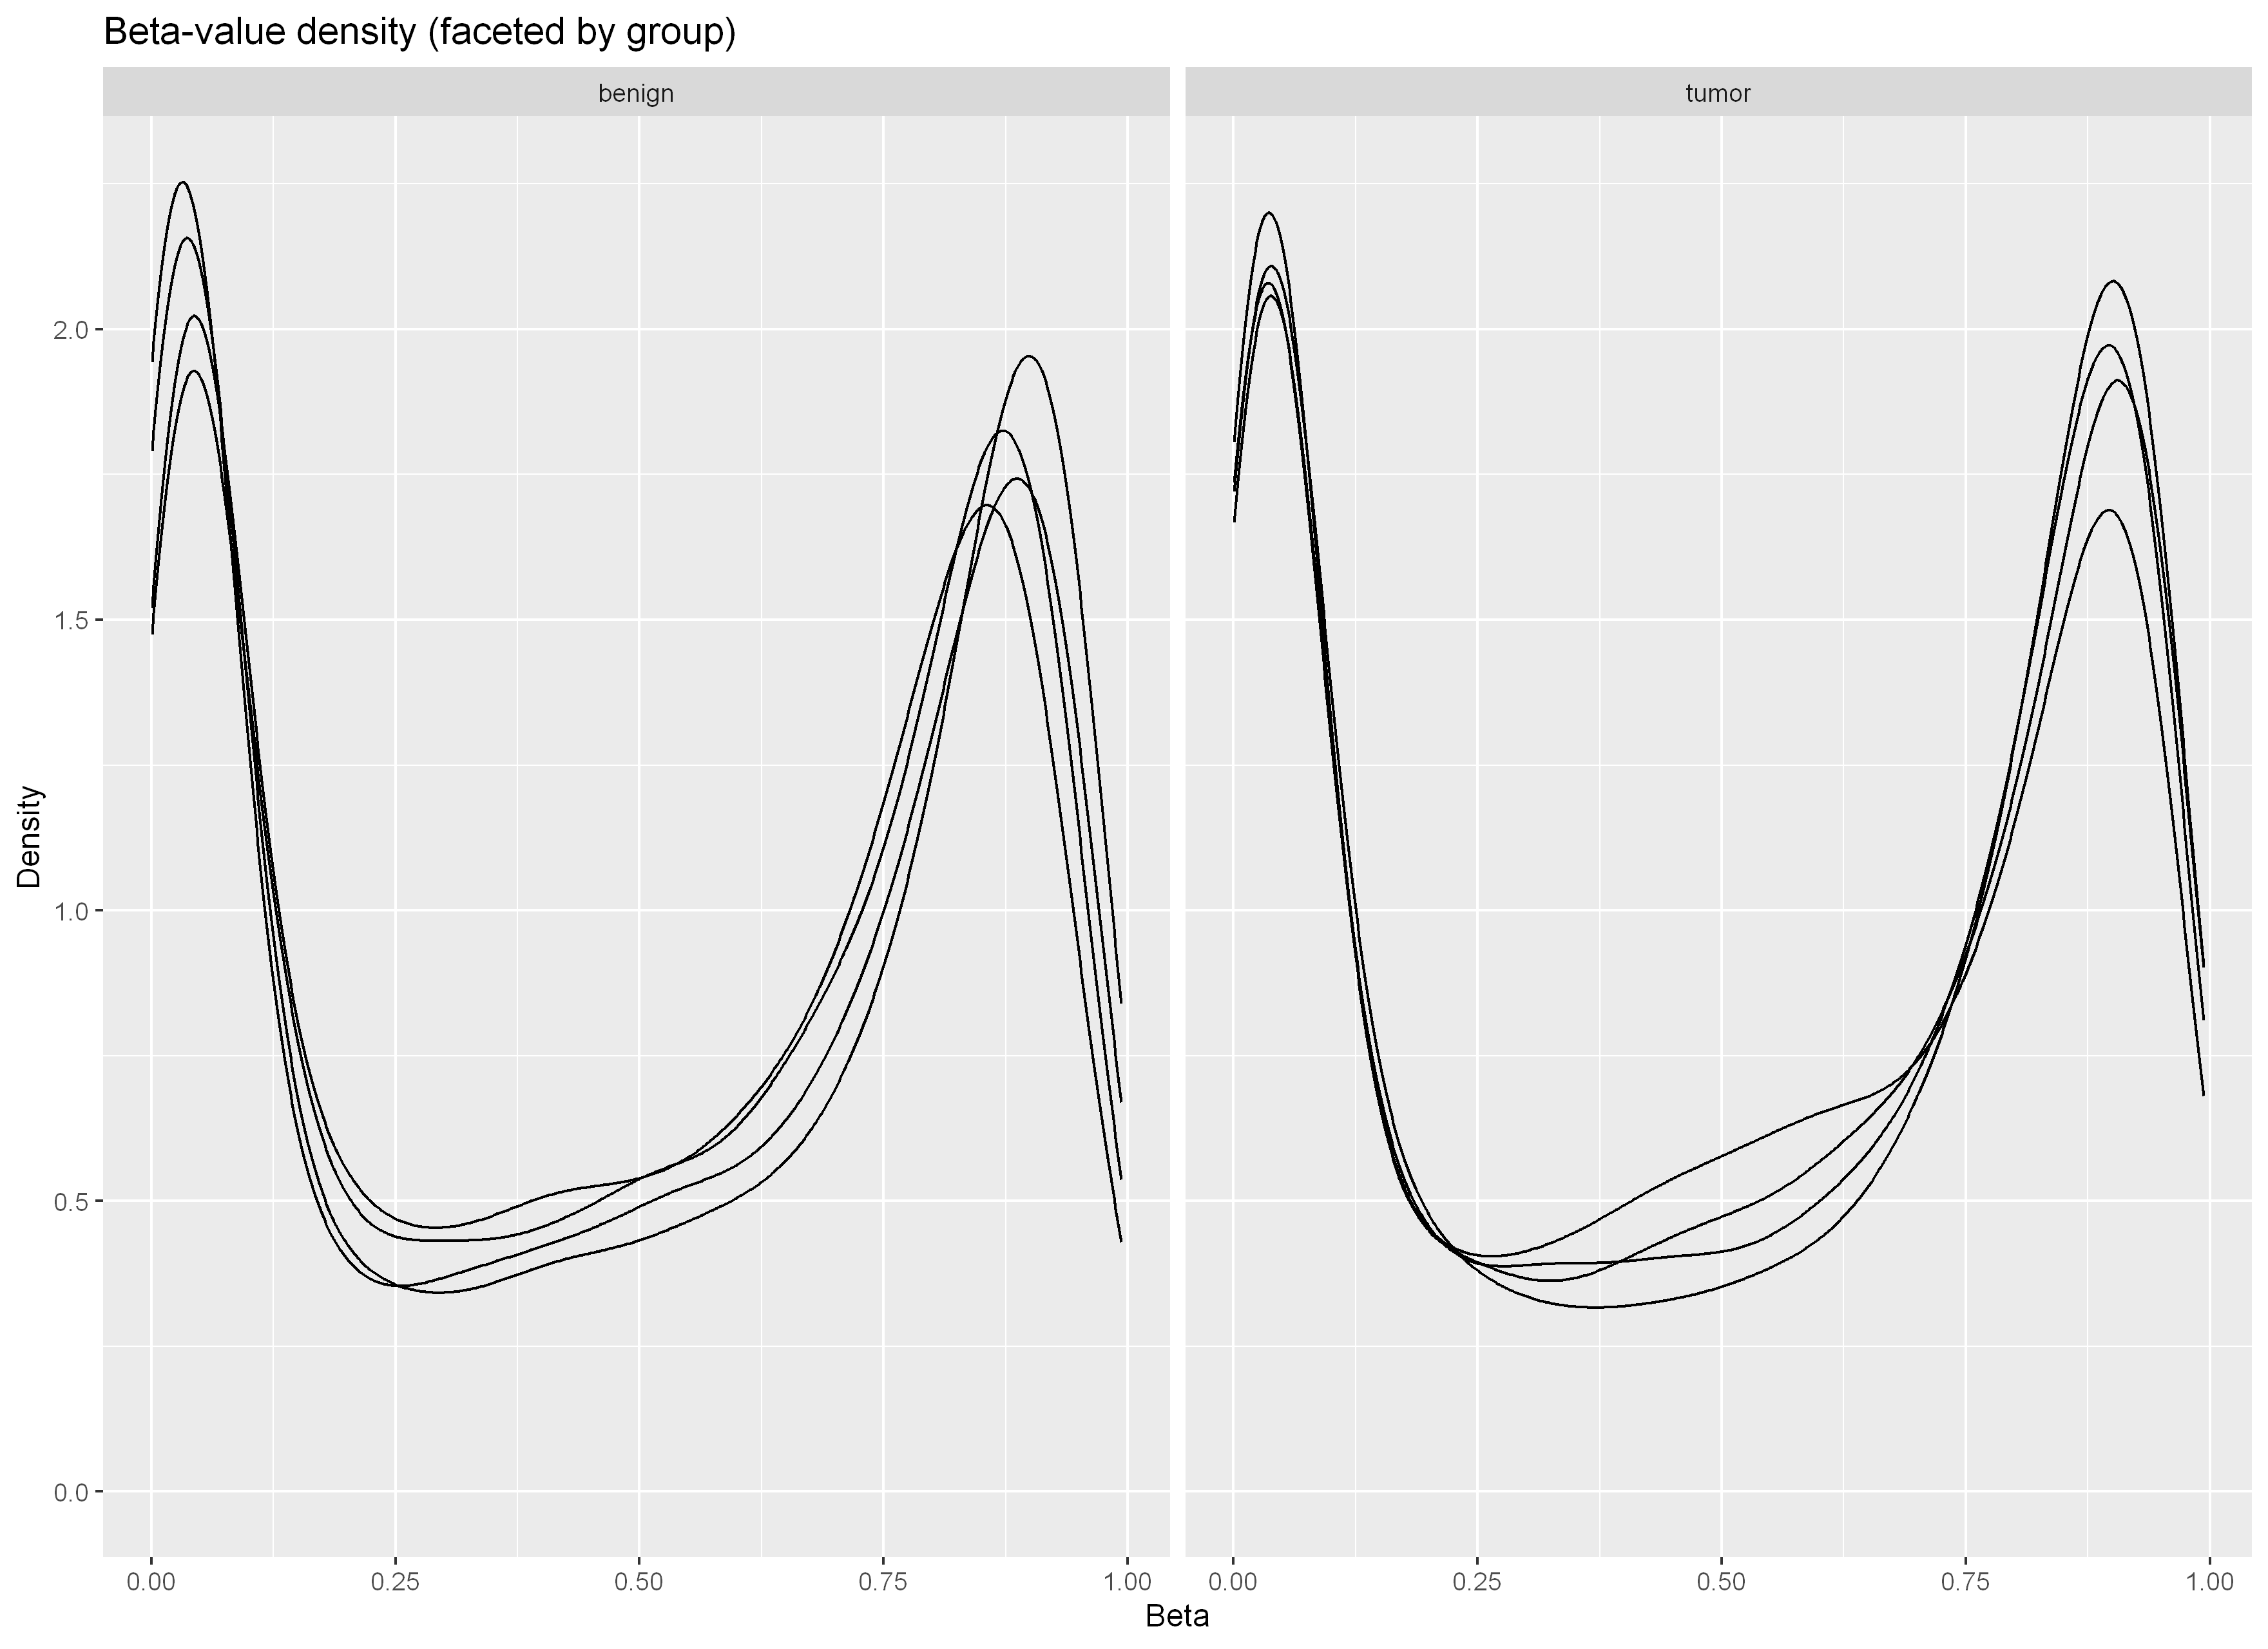

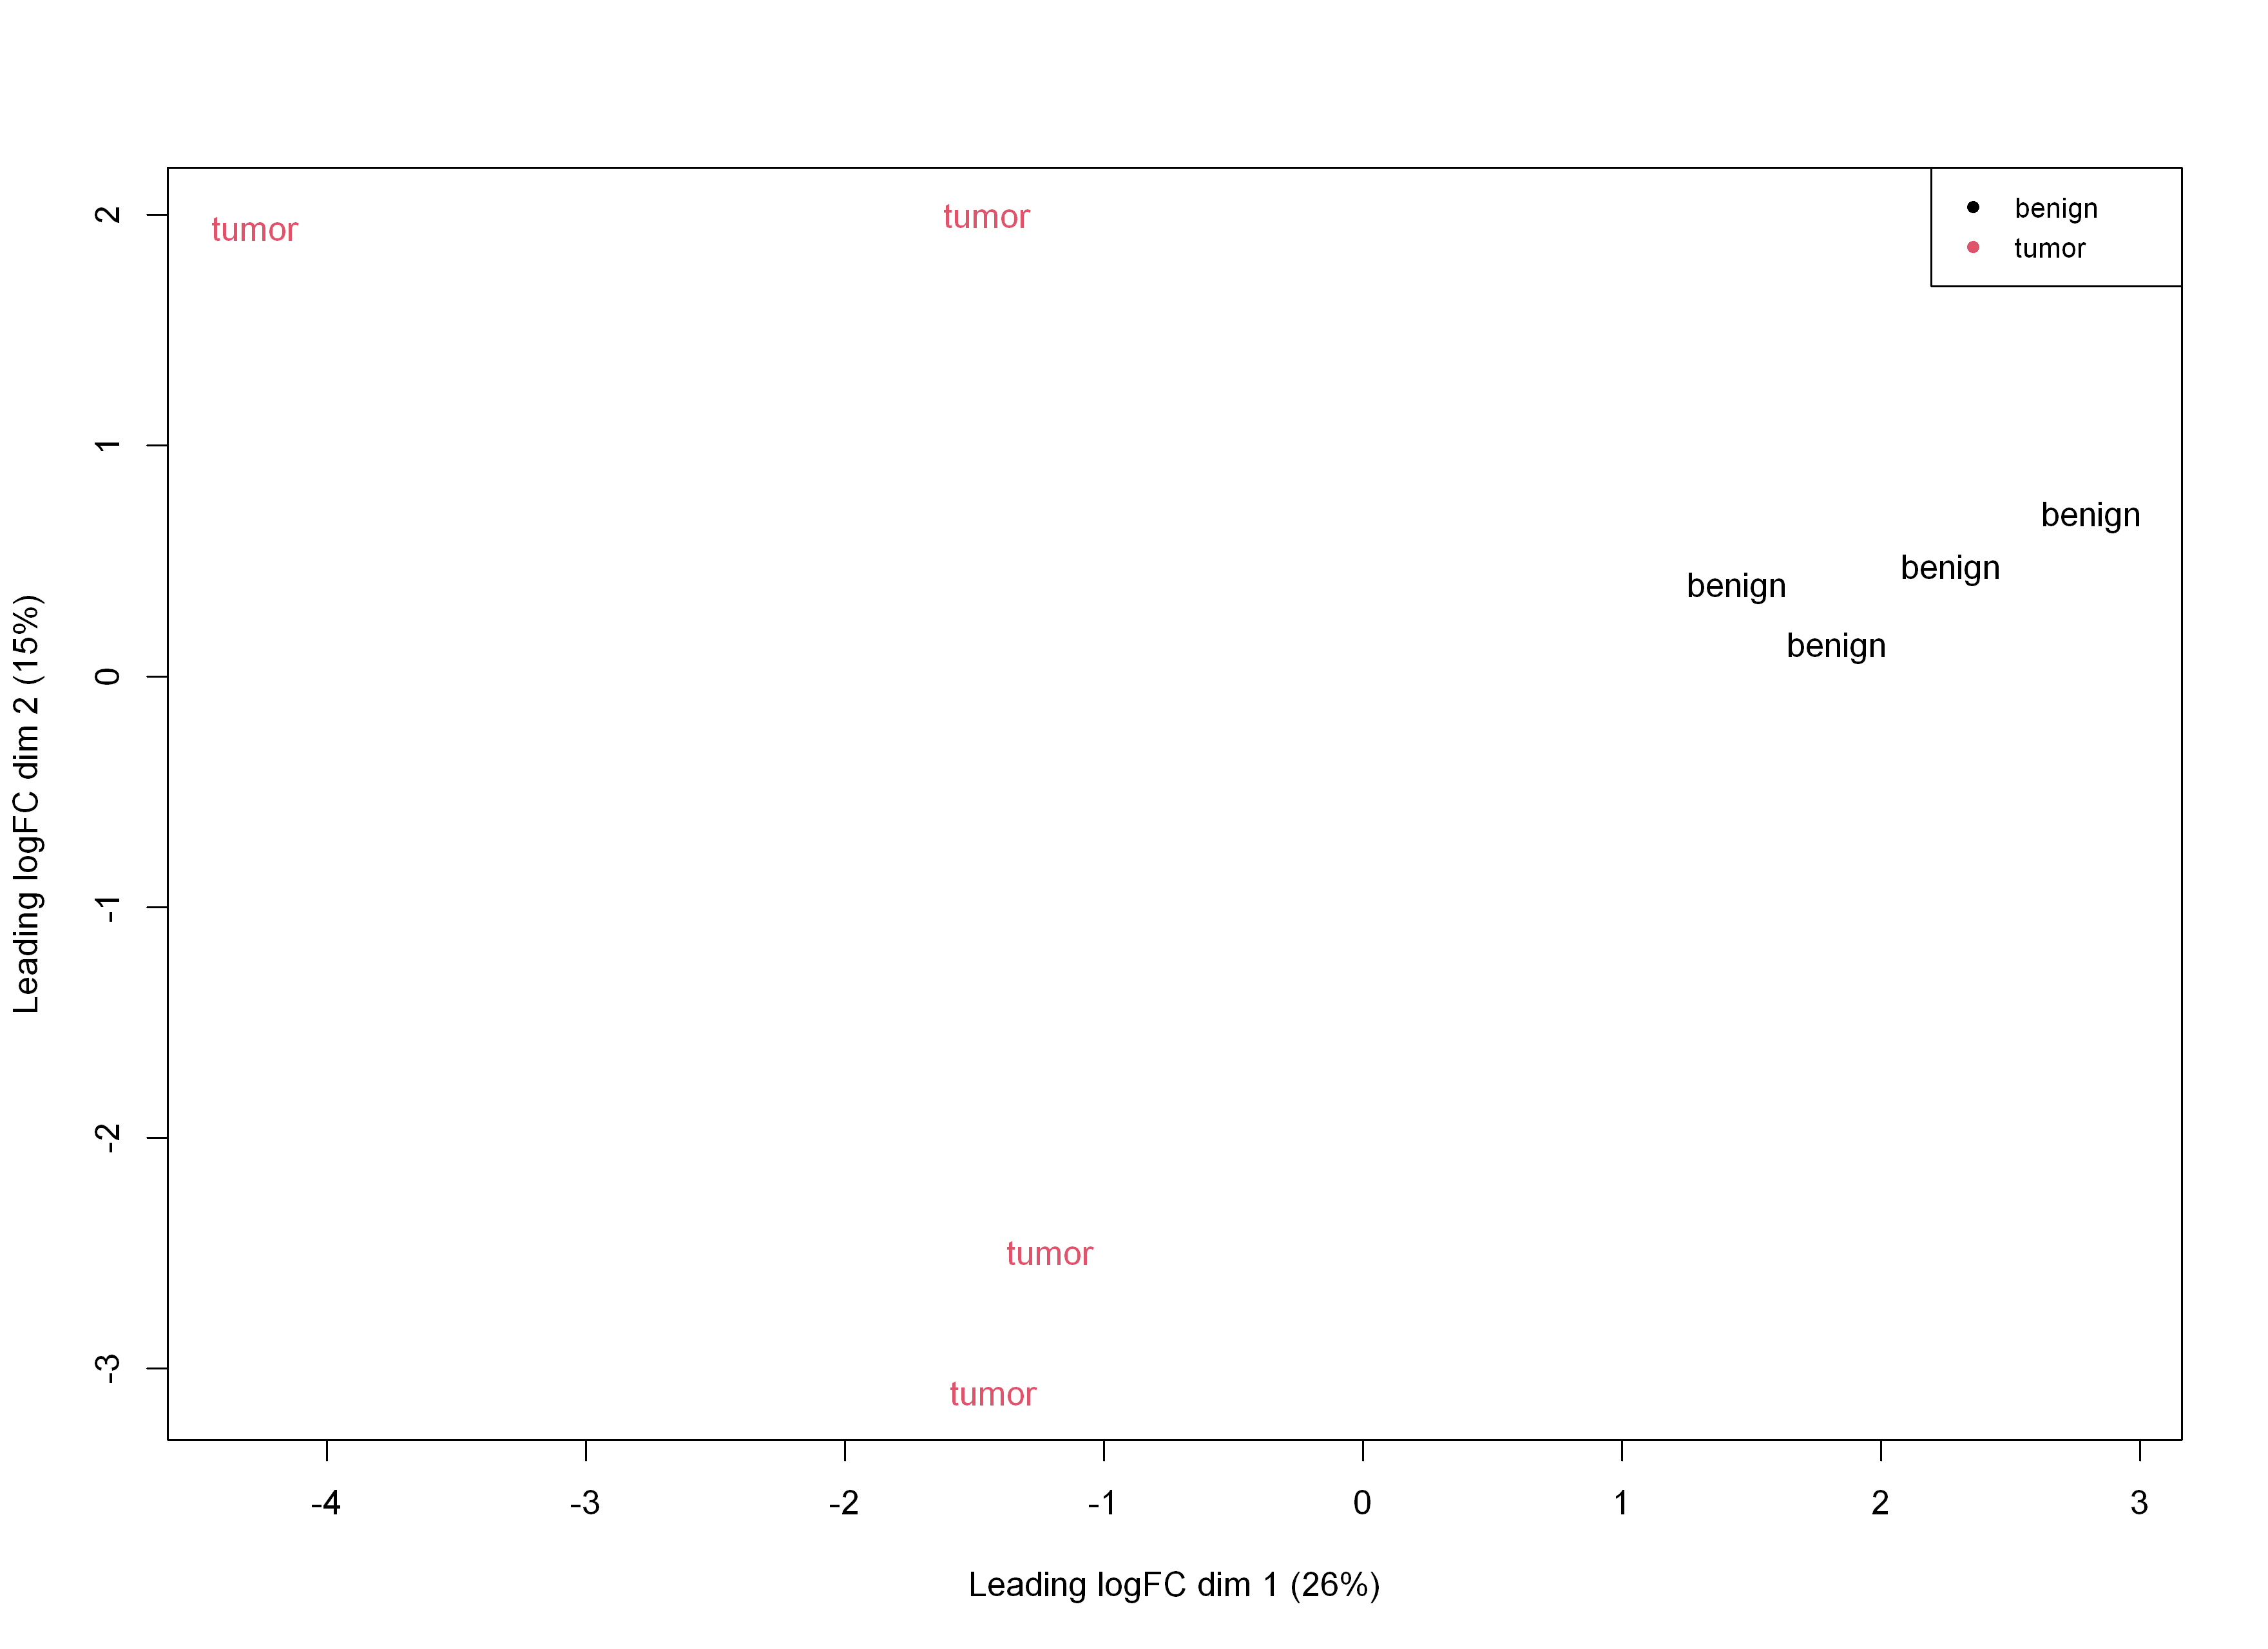

In [11]:
gSet <- minfi::preprocessFunnorm(rgSet)   # Functional normalization
beta <- minfi::getBeta(gSet)
mvals <- minfi::getM(gSet)

pheno <- as.data.frame(colData(gSet))
group <- factor(pheno$Sample_Group)  # should match the order of columns in beta/mvals


idx <- sample(seq_len(nrow(beta)), 10000)
beta_long <- data.frame(
  beta   = as.vector(beta[idx, , drop = FALSE]),
  sample = rep(colnames(beta), each = length(idx)),
  group  = rep(group, each = length(idx))
)

ggplot(beta_long, aes(x = beta, group = sample)) +
  geom_density(alpha = 0.15) +
  facet_wrap(~group, ncol = 2) +
  labs(title = "Beta-value density (faceted by group)", x = "Beta", y = "Density")


plotMDS(mvals, labels = group, col = as.integer(group))
legend("topright", legend = levels(group), col = seq_along(levels(group)), pch = 16, cex = 0.8)

## 5) Filter probes by detection p-value

Keep probes that pass P ≤ 0.01 in ≥ 90% of samples.
This step reduces false positives driven by missing/failed measurements.

One thing to keep in mind is the potential loss of biological relevance. For example, dropped probes may include loci affected by SNPs that are relevant to your research question.

In [5]:
keep_probes <- rowMeans(detP <= 0.01, na.rm = TRUE) >= 0.90
sum(keep_probes)

gSet <- gSet[keep_probes, ]
mvals <- minfi::getM(gSet)
beta <- minfi::getBeta(gSet)

[1] 483894

## 6) Differential methylation at CpG sites (DMPs) with limma

We fit a linear model to M-values at each CpG to estimate the tumor − benign difference.
The coefficient `grouptumor` estimates the average methylation difference (tumor − benign) on the M-value scale.

A common interpretation step is pairing statistical significance with effect size (e.g., |Δβ| ≥ 0.10).


In [6]:
# collect the sample metadata to label the groups (tumor vs benign)
group <- factor(colData(gSet)$Sample_Group, levels = c("benign", "tumor"))

# fit an intercept + a tumor-vs-benign coefficient
design <- model.matrix(~ group)  # intercept = benign baseline; 'grouptumor' is tumor - benign
fit <- limma::lmFit(mvals, design)  # fits a linear model per CpG
fit <- limma::eBayes(fit)  # shrinks variance estimates across CpGs to stabilize inference
dmp <- limma::topTable(
  fit,
  coef = "grouptumor",  # tumor-vs-benign coefficient
  number = Inf,
  adjust.method = "BH"
)

dmp$delta_beta <- rowMeans(beta[, group == "tumor"]) -
                  rowMeans(beta[, group == "benign"])

table(dmp$adj.P.Val < 0.05)
head(dmp[, c("logFC", "P.Value", "adj.P.Val", "delta_beta")])
# logFC here is the difference in M-values (tumor - benign)


 FALSE   TRUE 
450945  32949 

,logFC,P.Value,adj.P.Val,delta_beta
,<dbl>,<dbl>,<dbl>,<dbl>
cg19670286,5.974145,2.428435e-10,3.213141e-05,0.004103729
cg24578679,5.762299,2.495149e-10,3.213141e-05,0.001732646
cg27299406,6.554142,3.253024e-10,3.213141e-05,-0.003973105
cg23511432,6.367987,4.184550e-10,3.213141e-05,0.043169239
cg14855334,5.687227,4.367081e-10,3.213141e-05,-0.001987741
cg20527270,6.182646,4.552085e-10,3.213141e-05,-0.109264806


### Volcano plot

You typically look for CpGs with both strong statistical support and meaningful methylation difference (e.g., |Δβ| ≥ 0.10), although smaller effects can matter in promoters/enhancers



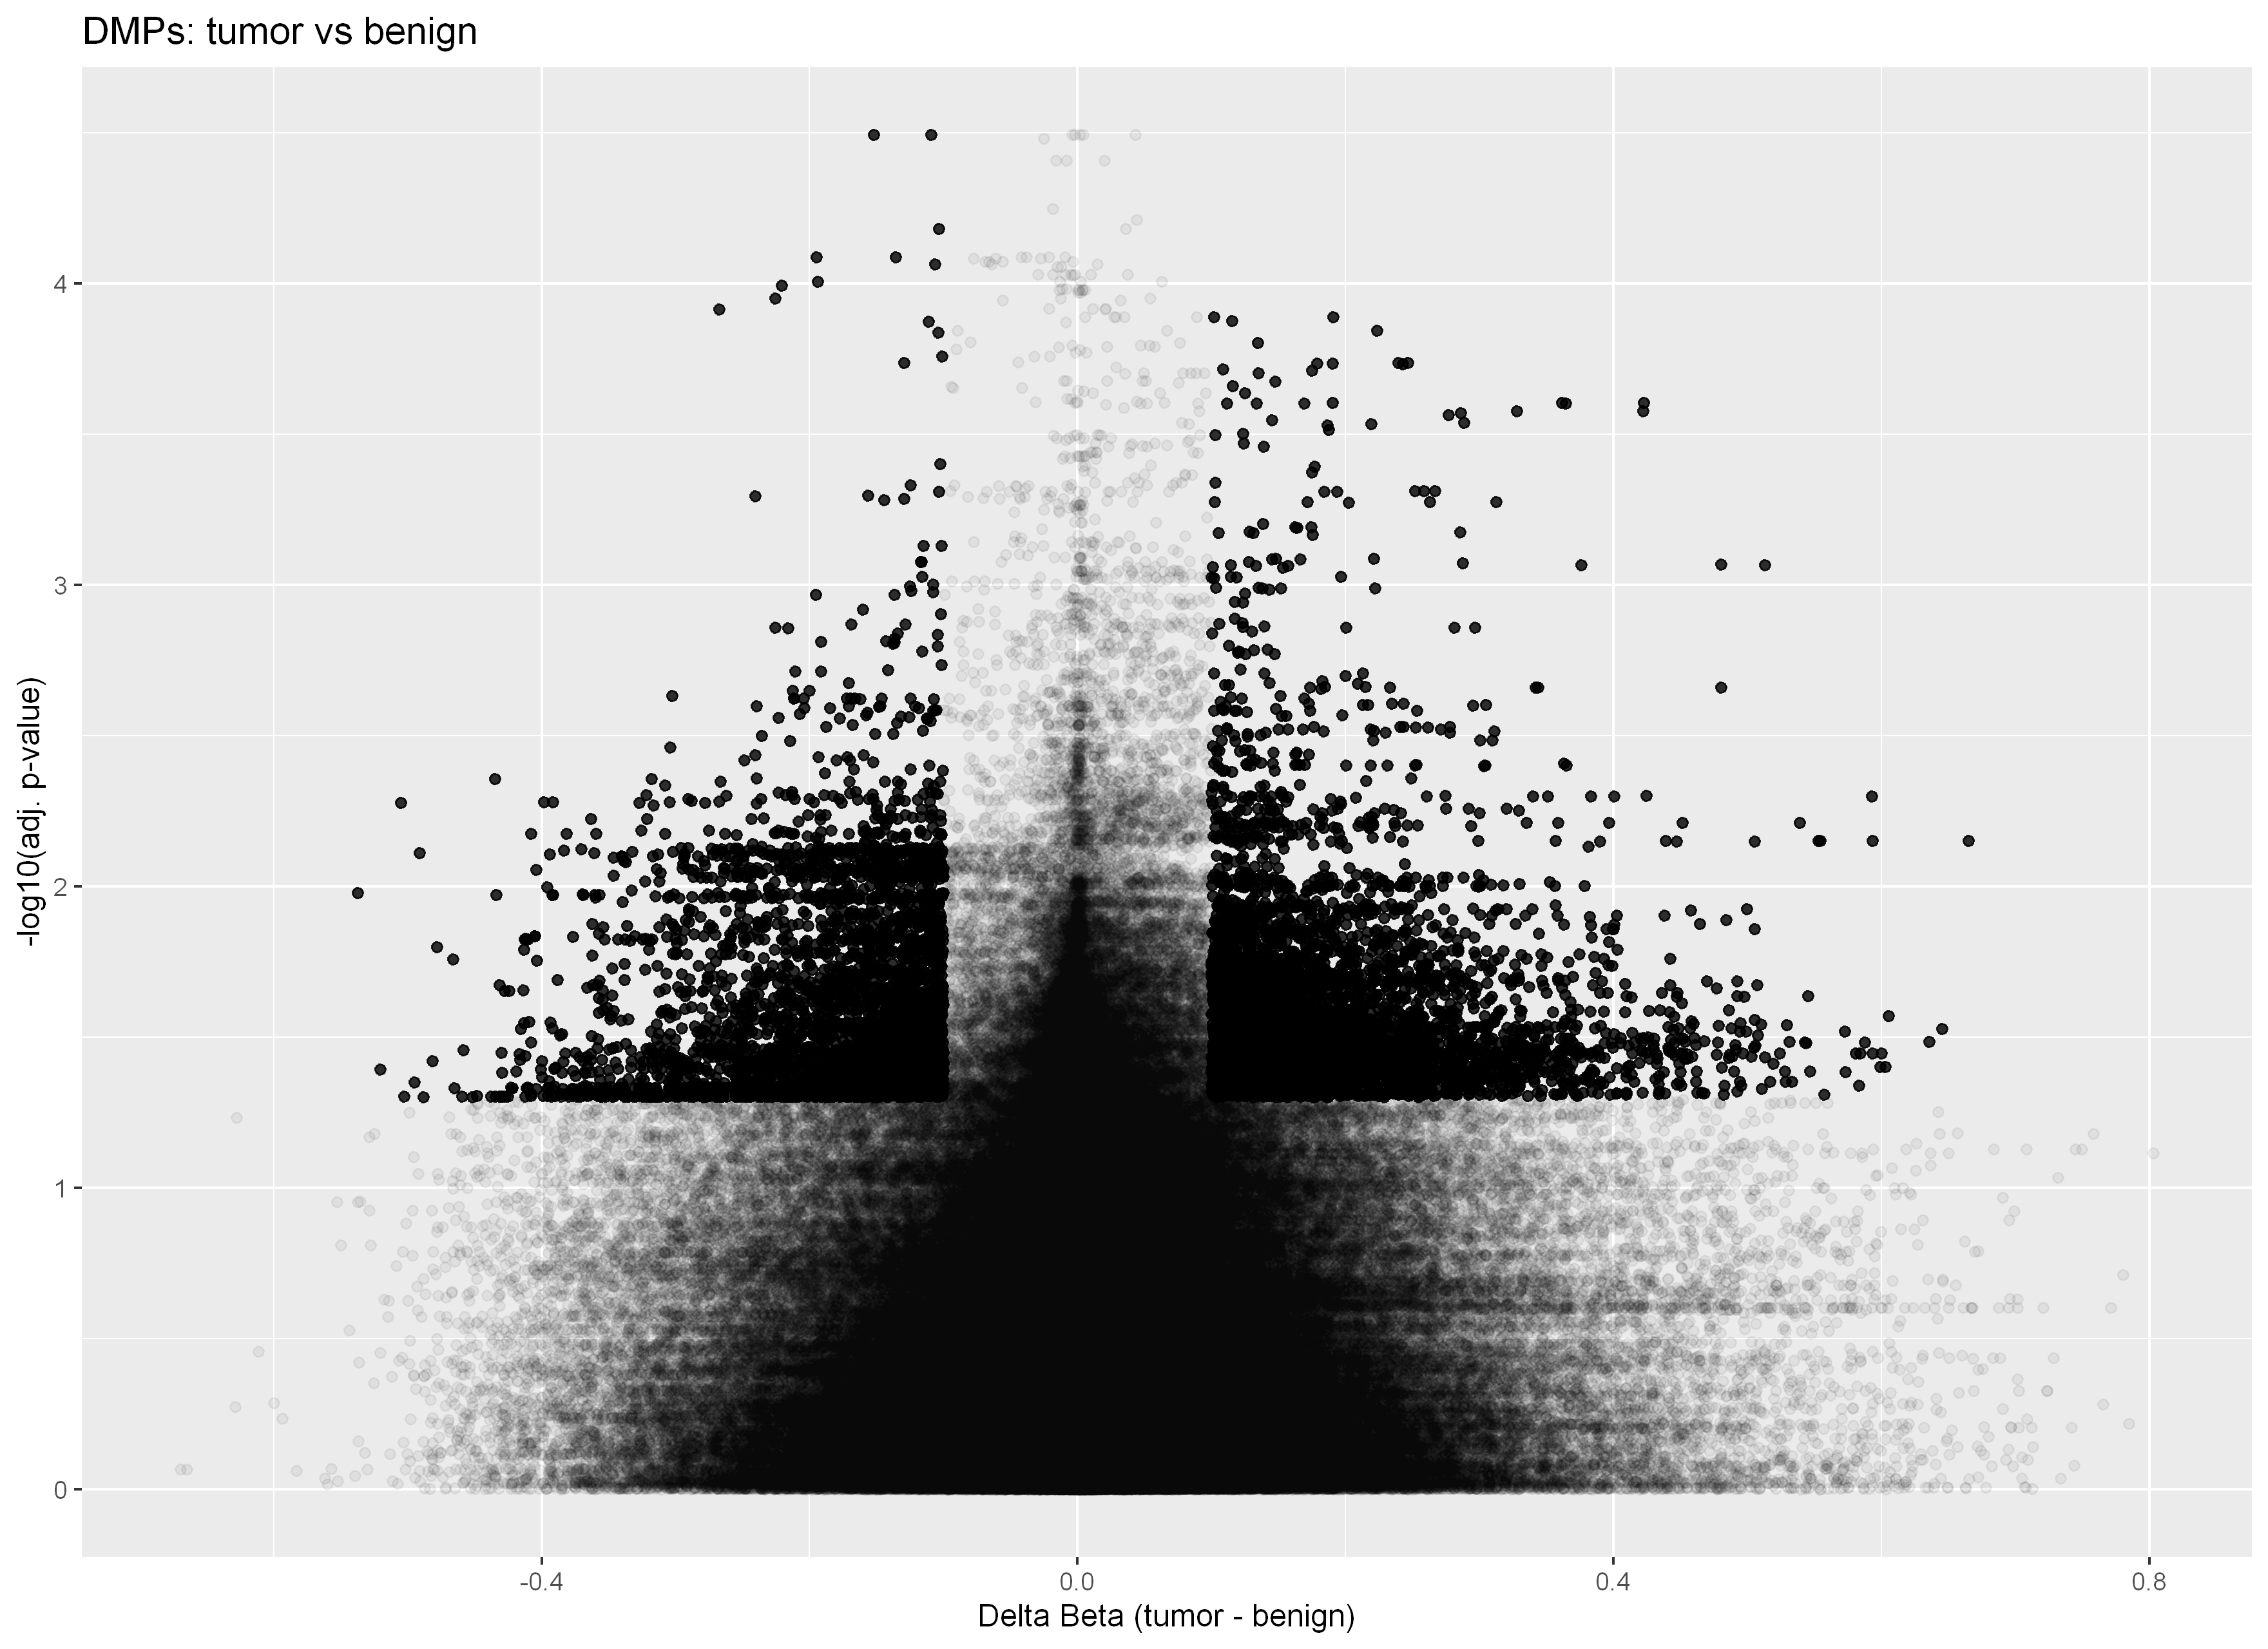

In [7]:
hit <- dmp$adj.P.Val < 0.05 & abs(dmp$delta_beta) >= 0.10

ggplot(dmp, aes(delta_beta, -log10(adj.P.Val))) +
  geom_point(alpha = 0.05) +
  geom_point(data = dmp[hit, ], alpha = 0.8) +
  labs(
    title = "DMPs: tumor vs benign",
    x = "Delta Beta (tumor - benign)",
    y = "-log10(adj. p-value)"
  )

#TODO: could be nice to label top hits and have a legend with the amount of hits

## 7) Regional differential methylation (DMRs) with DMRcate

DMRs are clusters of nearby CpGs that shift together, which often map more cleanly onto regulatory elements than individual CpGs.

DMRcate starts from CpG-level statistics and smooths signals across genomic neighborhoods.
`lambda` sets the bandwidth (how far CpGs can influence each other; ~1000 bp is common).
`C` controls how stringent clustering is (higher tends to call fewer, stronger regions).

`DMR.plot()` shows CpGs in the region, a heatmap of sample beta values, and group means across the region.


In [8]:
ann <- DMRcate::cpg.annotate(
  object = mvals,
  datatype = "array",
  what = "M",
  analysis.type = "differential",
  design = design,
  coef = 2,            # Sample_Grouptumor
  arraytype = "450K"
)

dmrc <- DMRcate::dmrcate(ann, lambda = 1000, C = 2)
dmrs <- DMRcate::extractRanges(dmrc, genome = "hg19")

Your contrast returned 32949 individually significant probes. We recommend the default setting of pcutoff in dmrcate().

Fitting chr1...

Fitting chr2...

Fitting chr3...

Fitting chr4...

Fitting chr5...

Fitting chr6...

Fitting chr7...

Fitting chr8...

Fitting chr9...

Fitting chr10...

Fitting chr11...

Fitting chr12...

Fitting chr13...

Fitting chr14...

Fitting chr15...

Fitting chr16...

Fitting chr17...

Fitting chr18...

Fitting chr19...

Fitting chr20...

Fitting chr21...

Fitting chr22...

Fitting chrX...

Fitting chrY...

Demarcating regions...

Done!

see ?DMRcatedata and browseVignettes('DMRcatedata') for documentation

loading from cache



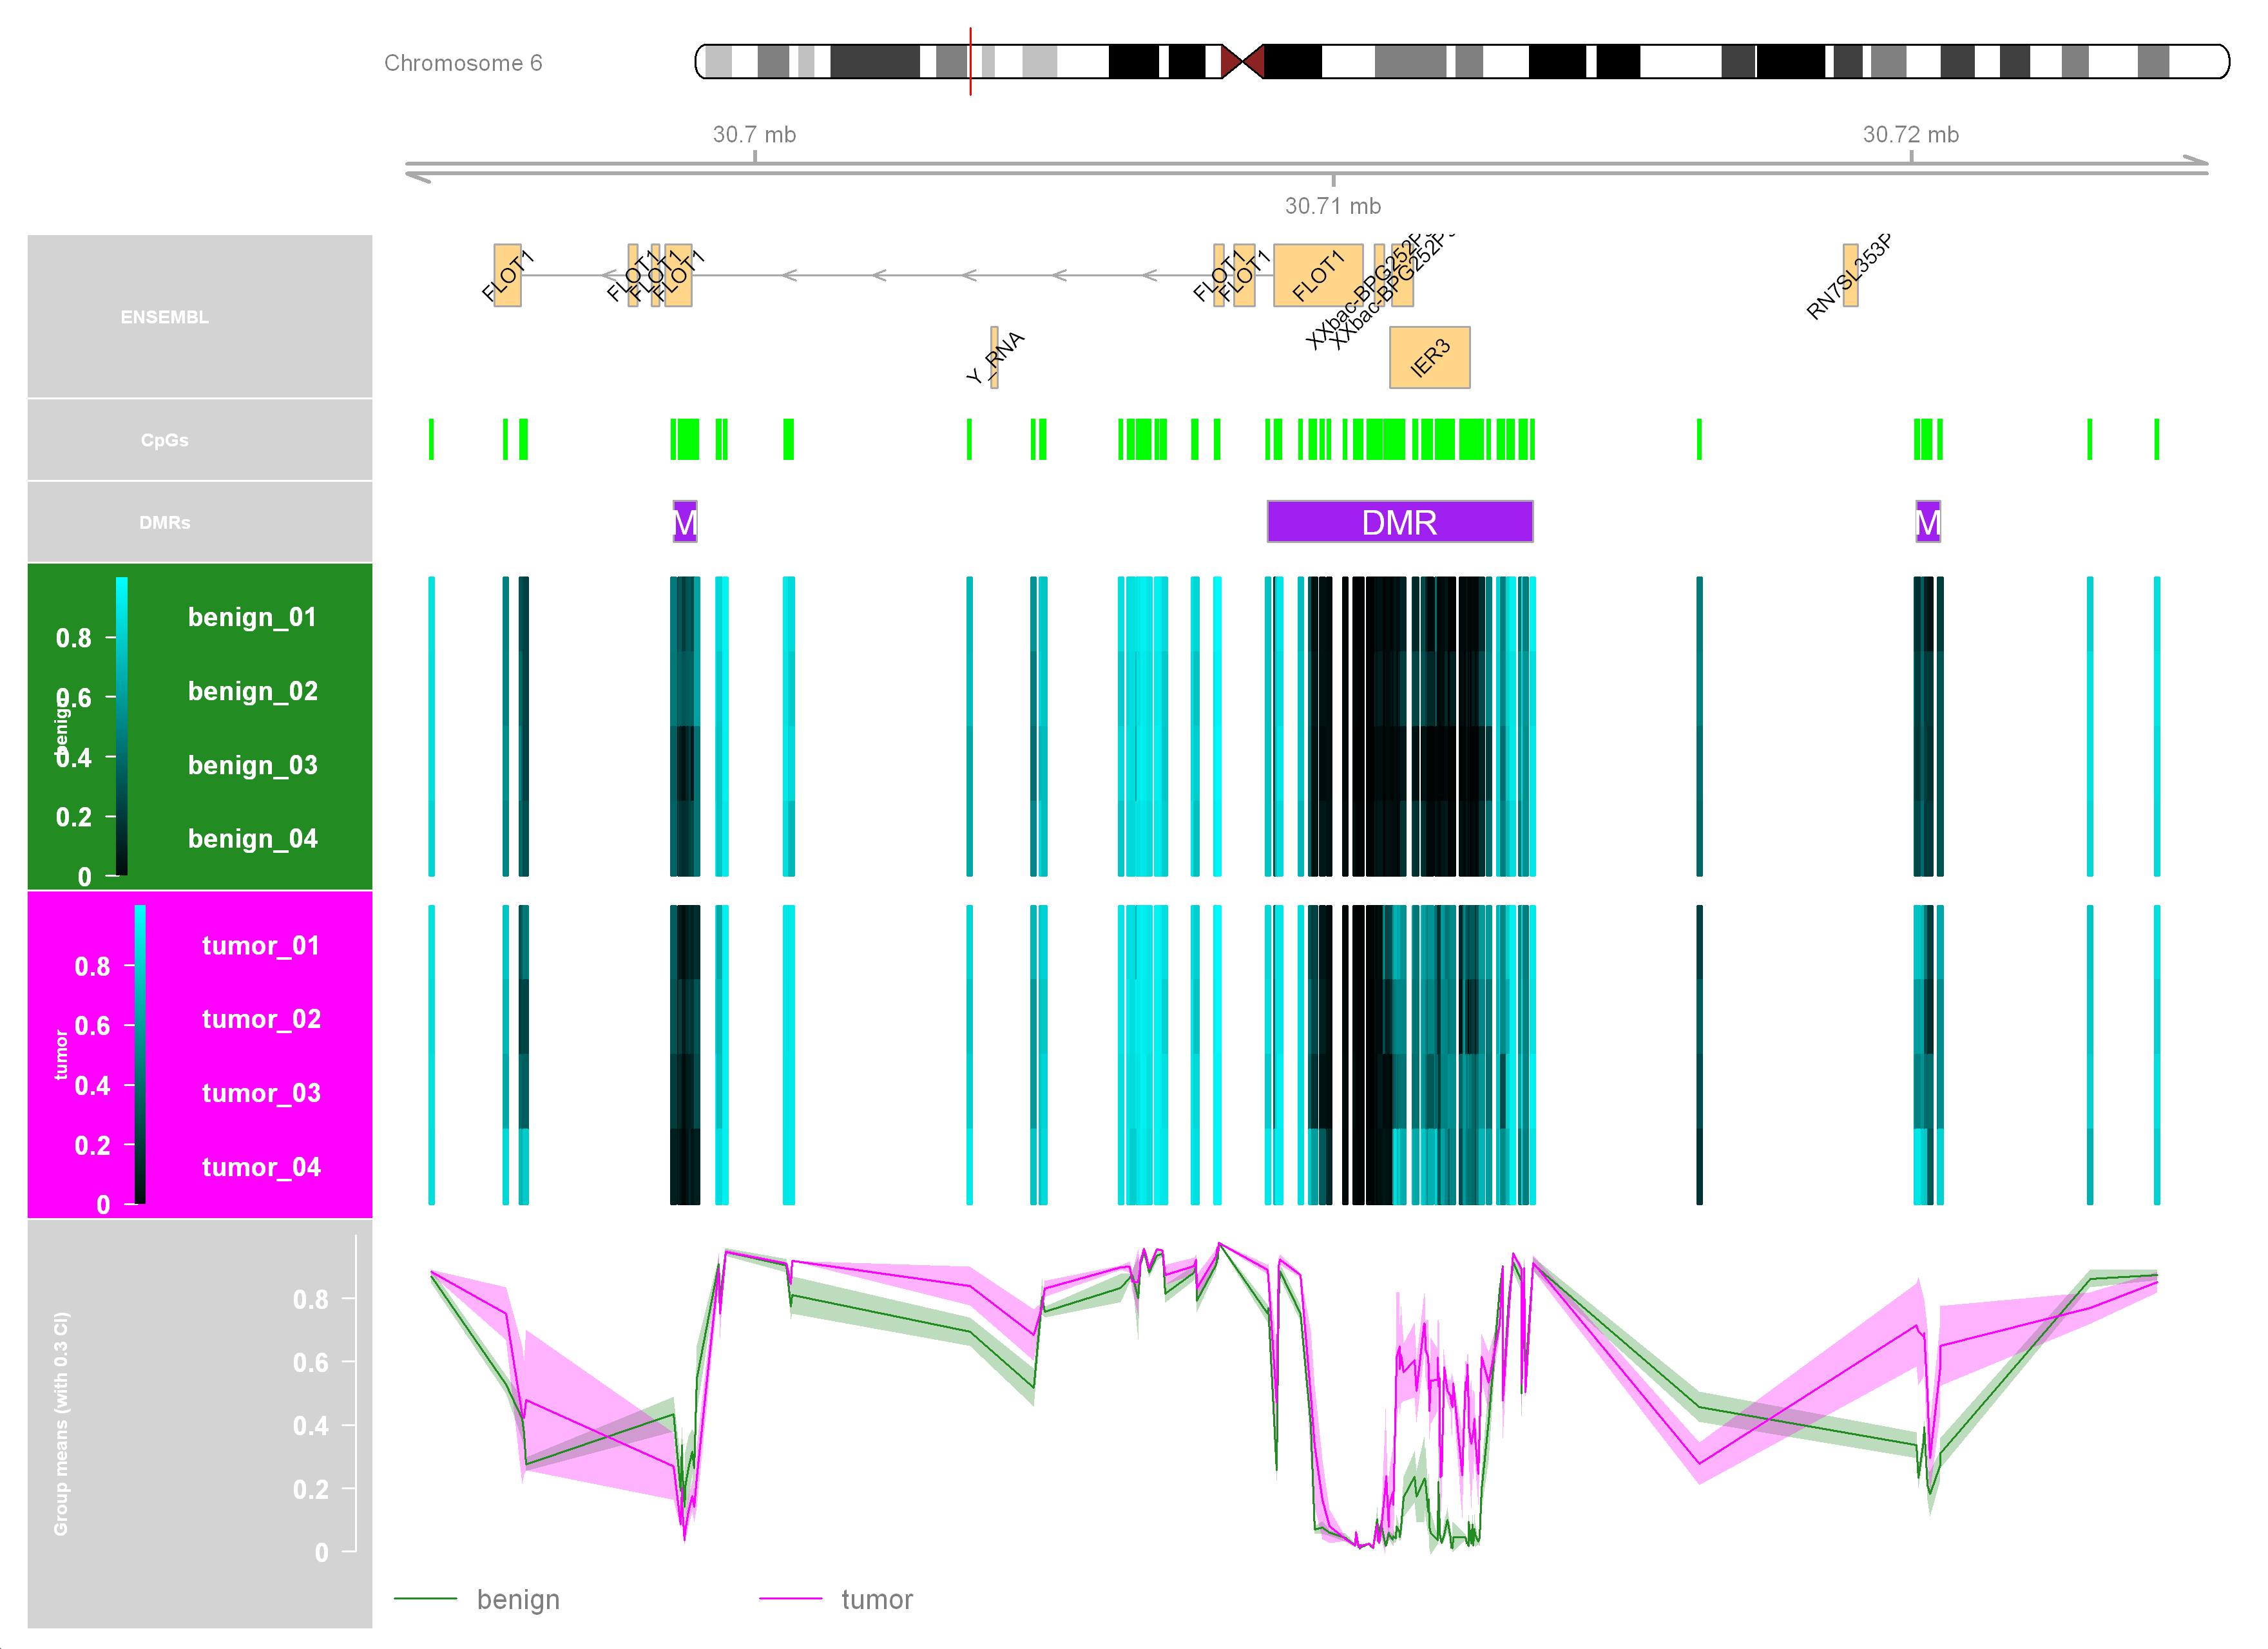

In [9]:
## Plot the top DMR
# Short column labels: benign_01, benign_02, tumor_01, ...
rep_id <- ave(seq_along(group), group, FUN = seq_along)
beta_plot <- beta
colnames(beta_plot) <- sprintf("%s_%02d", as.character(group), rep_id)

# DMR.plot expects a per-sample color vector (length == ncol(CpGs))
phen_cols <- c(benign = "forestgreen", tumor = "magenta")[as.character(group)]

DMRcate::DMR.plot(
  ranges    = dmrs,
  dmr       = 1,
  CpGs      = beta_plot,
  what      = "Beta",
  phen.col  = phen_cols,
  arraytype = "450K",
  genome    = "hg19"
)

## 8) Gene set enrichment (GO / KEGG) with missMethyl

Gene set testing for methylation arrays is tricky because genes have different numbers of probes on the array.  
`gometh()` adjusts for this probe-number bias (and multi-gene mapping), which makes enrichment results more trustworthy.

Note that for these results to be useful we would want to split each by "higher in tumor / lower in benign" and "lower in tumor / higher in benign"

All input CpGs are used for testing.



,ONTOLOGY,TERM,N,DE,P.DE,FDR
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GO:0071944,CC,cell periphery,5984,3359,1.391861e-22,3.073925e-18
GO:0005886,CC,plasma membrane,5531,3093,1.018562e-19,1.124747e-15
GO:0030054,CC,cell junction,2410,1512,1.082600e-16,7.969743e-13
GO:0007155,BP,cell adhesion,1550,962,9.877867e-14,5.453817e-10
GO:0009653,BP,anatomical structure morphogenesis,2826,1697,1.359342e-12,6.004212e-09
GO:0098590,CC,plasma membrane region,1326,827,9.969346e-12,3.496517e-08
GO:0048513,BP,animal organ development,3108,1826,1.108246e-11,3.496517e-08
GO:0070161,CC,anchoring junction,908,592,7.263864e-11,2.005280e-07
GO:0048731,BP,system development,4182,2423,8.492899e-11,2.084063e-07


All input CpGs are used for testing.



,Description,N,DE,P.DE,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
hsa04382,Cornified envelope formation,207,128,1.463827e-06,0.0005401523
hsa04820,Cytoskeleton in muscle cells,233,159,1.193421e-05,0.0022018618
hsa04360,Axon guidance,181,133,4.196700e-05,0.0050093383
hsa05414,Dilated cardiomyopathy,104,78,5.547203e-05,0.0050093383
hsa05412,Arrhythmogenic right ventricular cardiomyopathy,86,67,6.787721e-05,0.0050093383
hsa04510,Focal adhesion,201,138,2.788721e-04,0.0171506360
hsa04518,Integrin signaling,153,107,4.366004e-04,0.0230150768
hsa04930,Type II diabetes mellitus,46,38,5.136720e-04,0.0236931200
hsa05410,Hypertrophic cardiomyopathy,99,71,6.267979e-04,0.0256987152


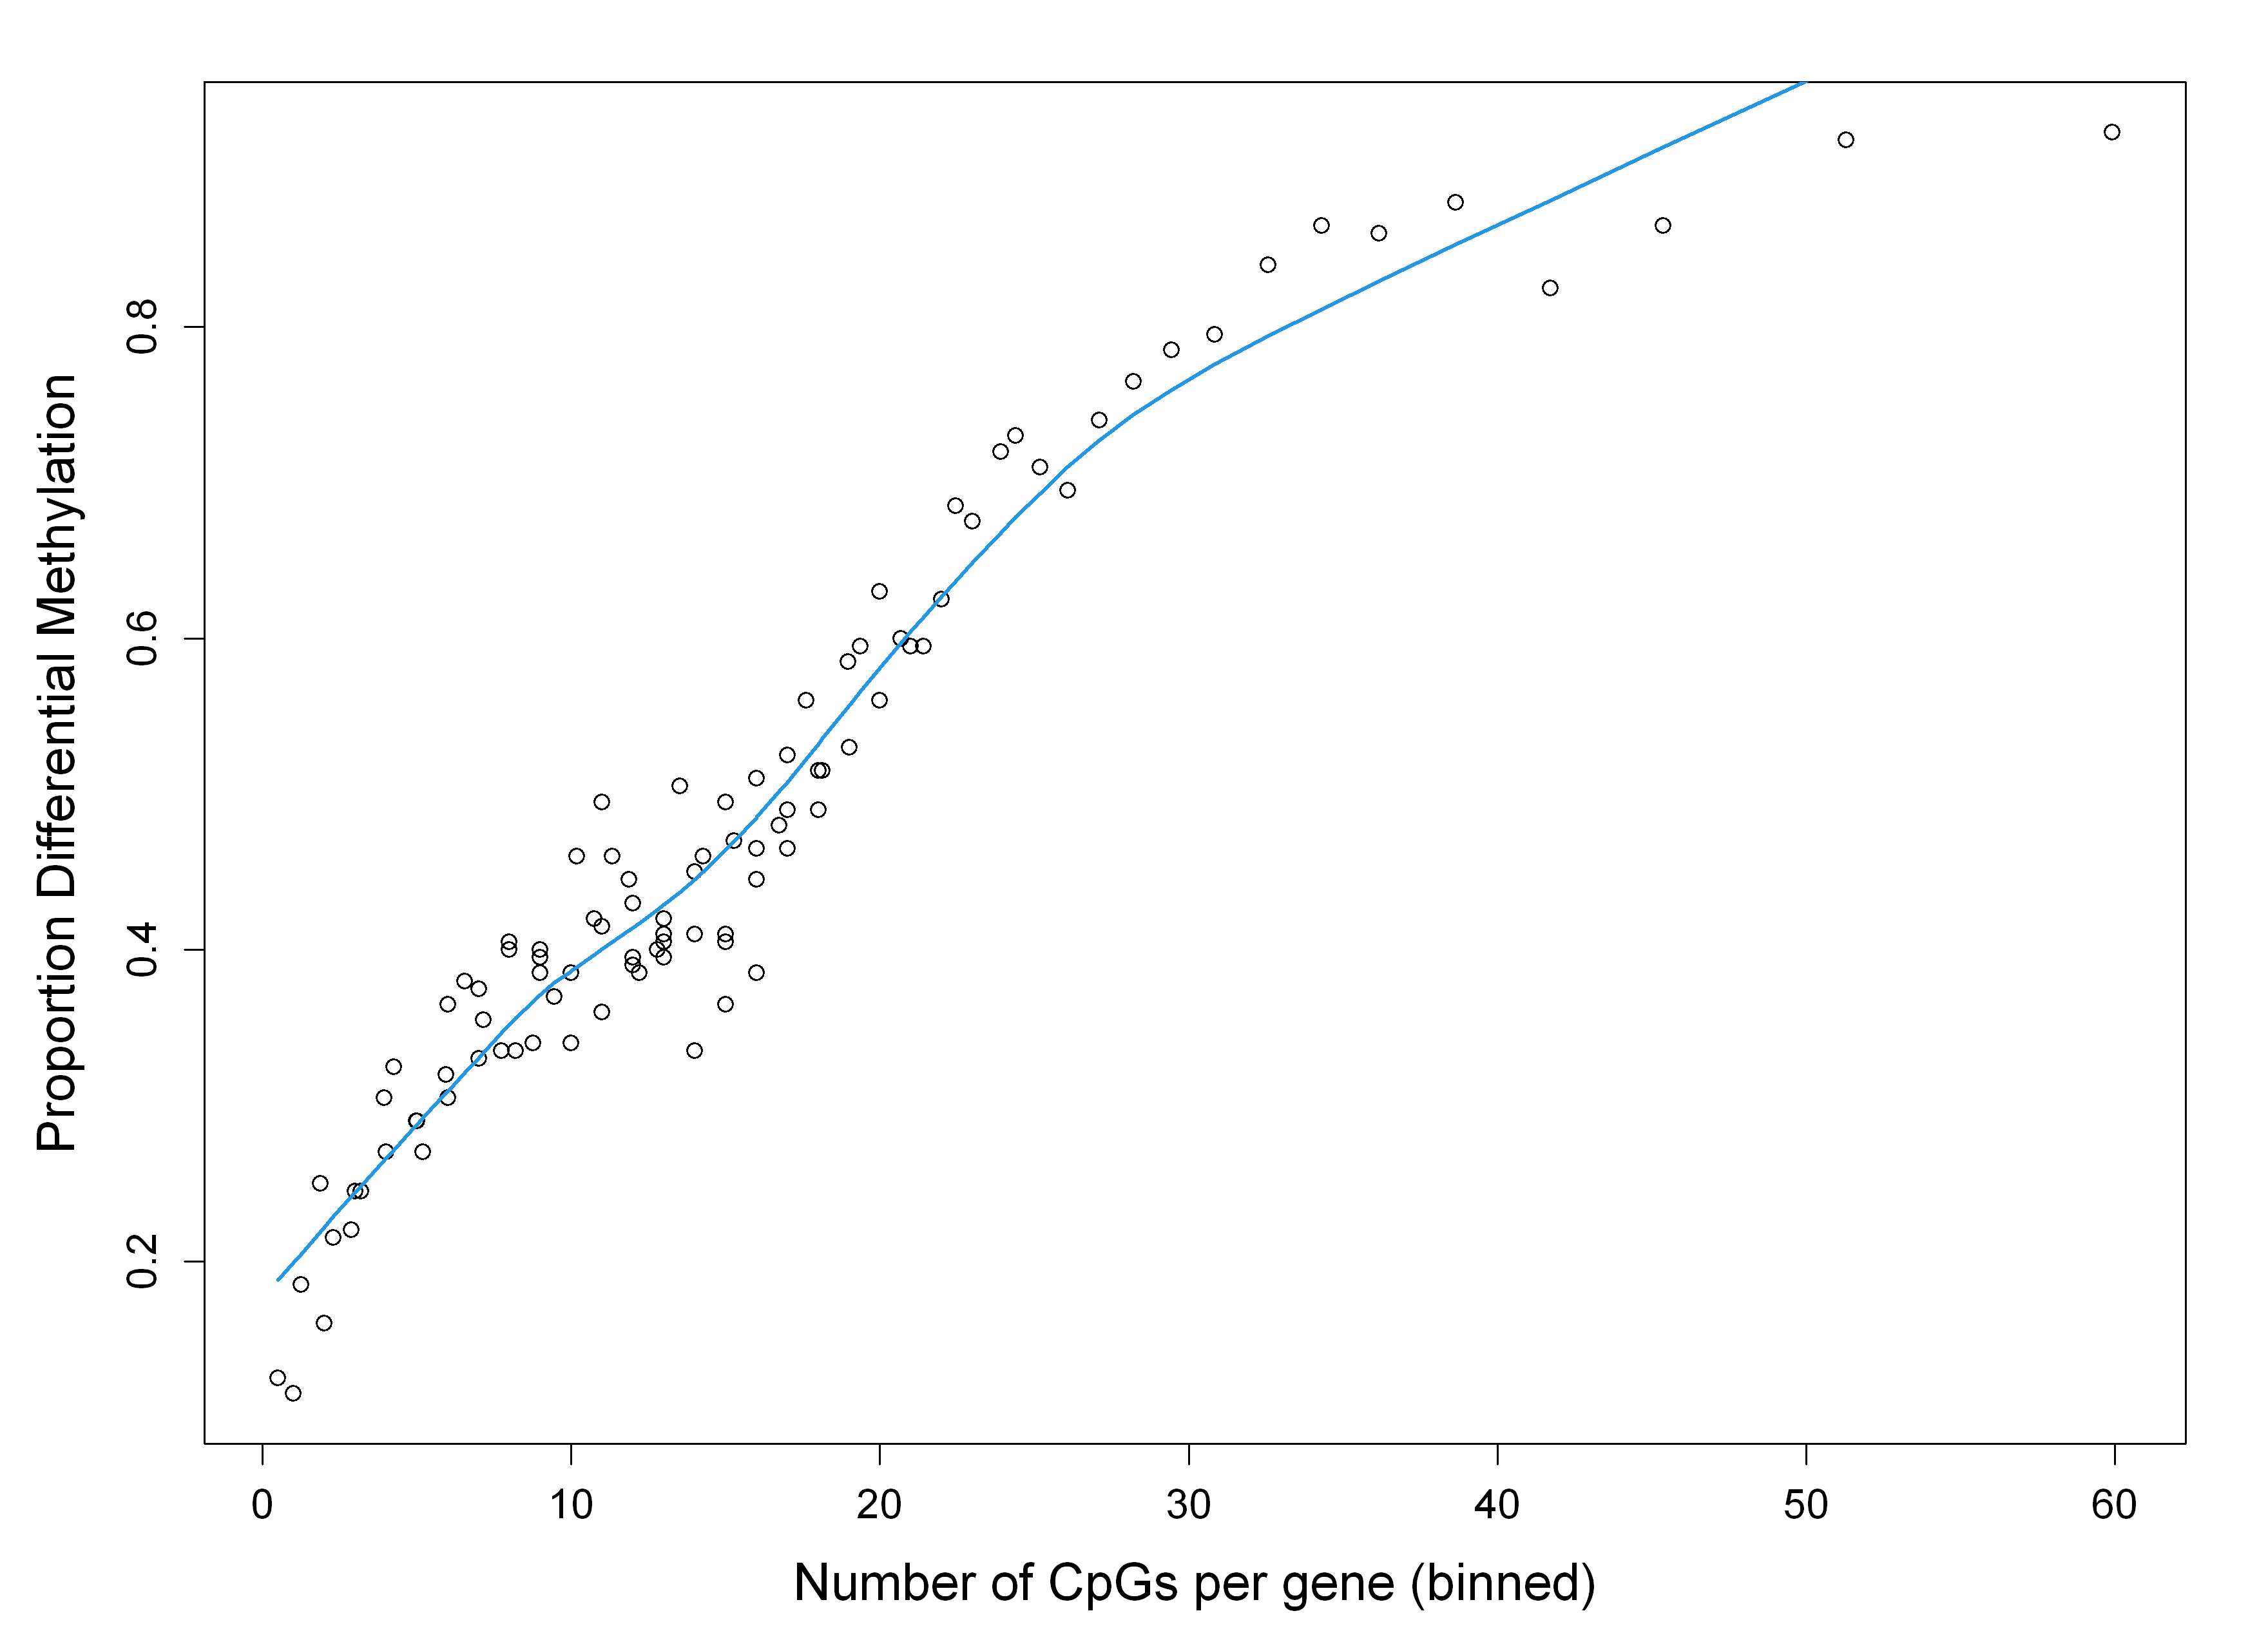

In [10]:
all_cpg <- rownames(mvals)
sig_cpg <- rownames(dmp)[dmp$adj.P.Val < 0.05]

topGSA(gometh(sig_cpg, all_cpg, collection = "GO", array.type = "450K", plot.bias = TRUE), 10)
topGSA(gometh(sig_cpg, all_cpg, collection = "KEGG", array.type = "450K"), 10)

## Additional considerations

- **Probe filtering**: you’ll usually remove cross-reactive probes, probes with common SNPs at the CpG or single-base extension, and (depending on your design) sex chromosome probes.
- **Batch effects**: if you have slide/plate/run information, include it in the design matrix (or use `duplicateCorrelation` / mixed models).
- **Cell composition**: for whole blood or tissues, estimate and adjust cell proportions (e.g., `estimateCellCounts`)

## Typical follow-ups

- Plot methylation across specific loci of interest and link to expression if available.
- Integrate with RNA-seq to connect methylation changes to expression changes.
- Integrate with ATAC-seq/ChIP-seq to interpret DMRs in regulatory context.
